In [1]:
import utils
import pandas as pd
import dowhy
from dowhy import CausalModel

c:\Users\antonio\anaconda3\envs\causal_ds_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
lalonde_original, nswre_df, cps_control, psid_control, cps2_control, cps3_control, psid2_control, psid3_control = utils.load_data()

In [4]:
final_df = pd.concat([nswre_df[nswre_df["treatment"]==1], cps2_control], axis=0)

Now we load the different graphs generated from the Causal Discovery Colab Notebook

In [5]:
# Usage example:
graph = utils.extract_CD_graph("nswre_cps")

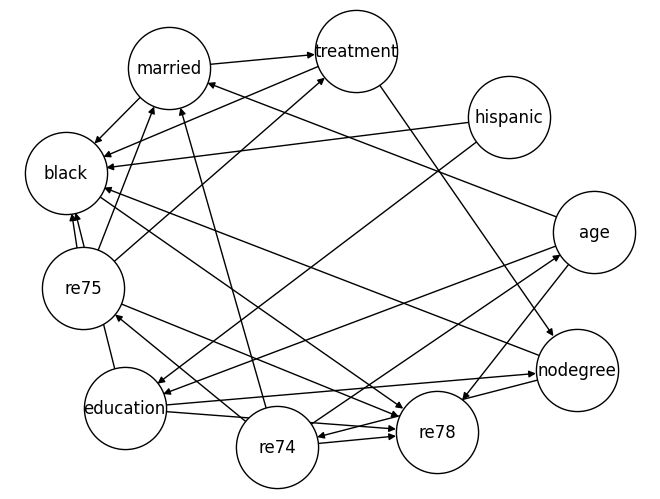

In [6]:
utils.draw_graph(graph)

## Identifying Estimands

In [7]:

lalonde_model = CausalModel(
                data=final_df,
                treatment='treatment',
                outcome='re78'
            )

In [8]:
#Identify the causal effect for the ihdp dataset
lalonde_identified_estimand = lalonde_model.identify_effect(proceed_when_unidentifiable=True)
print(lalonde_identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d               
────────────(E[re₇₈])
d[treatment]         
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→re78 then P(re78|treatment,,U) = P(re78|treatment,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



## Estimating the Causal Effect

In [14]:
lalonde_estimate = lalonde_model.estimate_effect(
                    lalonde_identified_estimand,
                    method_name="backdoor.linear_regression"
                )

print("The Causal Estimate is " + str(lalonde_estimate.value))

The Causal Estimate is -3821.967429785601


c:\Users\antonio\anaconda3\envs\causal_ds_env\Lib\site-packages\dowhy\causal_estimators\regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [10]:
import statsmodels.api as sm

covariates = ["treatment",  "age", "education", "black" , "hispanic", "married", "nodegree", "re74"]
# Assuming X is the treatment variable and Y is the outcome variable
# data should contain the variables X and Y, along with any other relevant variables
# Perform ordinary least squares (OLS) regression
model = sm.OLS(final_df['re78'], sm.add_constant(final_df[covariates]))
results = model.fit()

# Get the estimated causal effect
causal_effect = results.params[covariates]

print("Estimated causal effect:", causal_effect)

Estimated causal effect: treatment     942.770721
age           -95.123019
education     310.754407
black       -1211.227260
hispanic      414.573563
married       310.434596
nodegree      317.944093
re74            0.576245
dtype: float64


# Sensitivity Analysis